In [1]:
import random
import string
import shutil
import os
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap
from qiskit_aer.primitives import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2

from simulation import (
    build_hamiltonian,
    cut_circuit,
    run_exact_sampler,
    run_mps_simulator_full,
    run_mps_simulator_knitted,
    run_statevector_simulator_full,
    reconstruct_expectation,
    reconstruct_expectation2,
    trotterization_circuit,
    trotterization_circuit_order2
)
from utils import circuit_data_dict, save_to_json

THIS IS THE CODE FOR RUNNING SUBEXPERIMENT A (THE IMPURITY) IN THE QC AND SUBEXPERIMENT B IN THE TENSOR NETWORK

=== Configuration ===
Number of spins in the bath: 8
Number of spins in the impurity: 5
Anisotropy (J): 0.98
External Magnetic Field (H): 1.0
Two-Qubit Gates: ['ZZ']
Single-Qubit Gates: ['X']
Trotter Repetitions: 5
Time Parameter (t): 0.01
Decreasing J Flag: True
Number of circuit samples: 30000
Number of shots (tensor simulation): 1000
=== Coupling Map === 


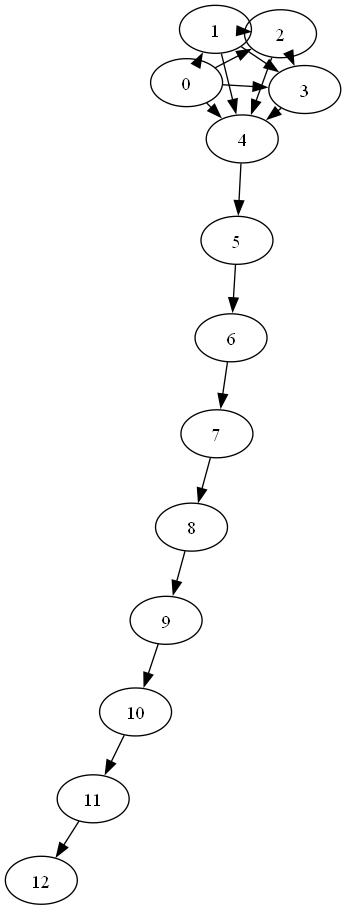

Obtained full circuit
Running simulation with full circuit
True expectation value: 0.9990009798182884
Running simulation with knitting
Obtained knitting subexperiments
Subcircuits data has been successfully saved to 'subcircuits\subcircuits-0.01.json'.
Subcircuits data has been successfully saved to 'expvals\coeffs_expvals-0.01.json'.


In [3]:
def main(config):
    # Define Coupling map for qubits and total number of qubits
    if config.MODEL == "impurity": 
        num_qubits = config.NUM_SPINS_BATH + config.NUM_SPINS_IMPURITY
    else:
        num_qubits = config.NUM_RINGS * config.NUM_SPINS
    edges = config.EDGES
    if config.PASS_TO_MPS == 'impurity':
        reversed_mapping = {i: num_qubits - 1 - i for i in range(num_qubits)}
        reversed_edges = [ (reversed_mapping[a], reversed_mapping[b]) for (a, b) in edges ]
        edges = reversed_edges

    coupling_map = CouplingMap(edges)
    if config.SHOW_CONFIG:
        config.display_configuration()
        print("=== Coupling Map === ")
        display(coupling_map.draw())
    
    # Better-looking coupling map plot (maybe for report)
    # plot_coupling_map(coupling_map, config.NUM_RINGS, config.NUM_SPINS)
    
    # Build Hamiltonian
    H = build_hamiltonian(
        num_qubits=num_qubits,
        coupling_map=coupling_map,
        decrease=config.DECREASING,
        initial_qubit_decrease=config.INDEX_DECREASE,
        single_gates=config.SINGLE_GATES_LIST,
        two_gates=config.TWO_GATES_LIST,
        anisotropy=config.ANISOTROPY,
        h=config.H_FIELD
    )

    odd_qubits = [i for i in range(num_qubits) if i % 2 == 1]
    impurity_qubits = [i for i in range(num_qubits) if i < config.NUM_SPINS_IMPURITY]
    initialState = QuantumCircuit(num_qubits)
    # initialState.x(range(num_qubits)) 

    #Obtain evolution circuit under TrotterLie approximation
    evolutionQC = trotterization_circuit(hamiltonian = H, trotter_reps = config.TROTTER_REPS, t = config.T)
    pm = generate_preset_pass_manager(optimization_level=3, basis_gates = ["h", "rx", "ry", "rz", "rxx","rzz","ryy"])
    totalQC = initialState.compose(evolutionQC) #Try option preserve_order
    # totalQC = pm.run(totalQC)
    # display(totalQC.draw('mpl', fold = False))
    print('Obtained full circuit')

    # Define observables (Z on each site, ZII + IZI + IIZ)
    # z_list = [('Z', [i], 1.0) for i in range(num_qubits)]
    if config.PASS_TO_MPS == 'impurity':
        z_list = [('Z', [i+config.NUM_SPINS_BATH], 1.0) for i in range(config.NUM_SPINS_IMPURITY)] # Only measuring operators in the impurity!!
        # z_list = [('Z', [i], 1.0) for i in range(config.NUM_SPINS_BATH)] # Only measuring operators in the bath!!
    elif config.PASS_TO_MPS == 'bath':
        z_list = [('Z', [i], 1.0) for i in range(config.NUM_SPINS_IMPURITY)] # Only measuring operators in the impurity!!
        # z_list = [('Z', [i+config.NUM_SPINS_IMPURITY], 1.0) for i in range(config.NUM_SPINS_BATH)] # Only measuring operators in the bath!!

    # Define observable (XXXX)
    z_list = [(config.NUM_SPINS_IMPURITY*'Z', np.arange(config.NUM_SPINS_IMPURITY), 1.0)]
    z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits=num_qubits)
    
    if num_qubits < 22:
        print('Running simulation with full circuit')
        true_expval = run_statevector_simulator_full(circuit=totalQC, observables=z_observables)
        # true_expval = run_mps_simulator_full(circuit=totalQC, observables=z_observables, shots=config.SHOTS_TENSOR)
    else: 
        true_expval = run_mps_simulator_full(circuit=totalQC, observables=z_observables, shots=config.SHOTS_TENSOR)
        # true_expval = np.nan # If the number of qubits is too large, we will not run the full circuit simulation; Check cheaper simulation methods
    print("True expectation value:", true_expval)

    if config.WITH_KNITTING:
        print('Running simulation with knitting')
        # Cut circuit and generate subexperiments
        if config.MODEL == "impurity":
            if config.PASS_TO_MPS == 'impurity':
                cutting_labels = "A"*config.NUM_SPINS_BATH + "B"*config.NUM_SPINS_IMPURITY
            else:
                cutting_labels = "A"*config.NUM_SPINS_IMPURITY + "B"*config.NUM_SPINS_BATH
        if config.MODEL == "ring":
            cutting_labels = ''.join([letter * config.NUM_SPINS for letter in string.ascii_uppercase[:config.NUM_RINGS]])
        if config.MODEL == "line":
            cutting_labels = "A" * config.NUM_SPINS

        subexperiments, coefficients, subobservables = cut_circuit(
            circuit=evolutionQC,
            partition_labels=cutting_labels,
            observables=z_observables,
            num_samples=config.N_SAMPLES)
        
        print('Obtained knitting subexperiments')   
        
        # results_tensor = run_mps_simulator_knitted(subexperiments,subobservables,coefficients, config.SHOTS_TENSOR)
        # print('Run tensor simulation of knitted circuits: ', results_tensor)

        subexperiments_QC = {}
        subexperiments_MPS = {}
        subobservables_QC = {}
        subobservables_MPS = {}
        
        subexperiments_QC["A"] = subexperiments["A"]
        subexperiments_MPS["B"] = subexperiments["B"]
        subobservables_QC["A"] = subobservables["A"]
        subobservables_MPS["B"] = subobservables["B"]

        # Run QC simulation
        results_QC = run_exact_sampler(subexperiments_QC)
        coeffs_expvals = reconstruct_expectation2(results_QC, coefficients, subobservables_QC, z_observables)
        
        # results_knitting = run_exact_sampler(subexperiments)

        # # Reconstruct Expectation Values
        # reconstructed_expval = reconstruct_expectation(
        #     results_knitting, coefficients, subobservables, z_observables
        # )
        # print("Reconstructed expectation value:", reconstructed_expval)
        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
            
        data_dict = circuit_data_dict(subexperiments_MPS, coefficients, float(true_expval), basis_gates)
        save_to_json(data_dict, filename= os.path.join(config.SUBCIRCUITS_PATH, f"subcircuits-{config.T}.json"))
        
        coeff_exp_dicts = [{"coeff": coeff, "exps": exp} for coeff, exp in coeffs_expvals]
        save_to_json(coeff_exp_dicts, filename= os.path.join(config.COEFFS_EXP_PATH, f"coeffs_expvals-{config.T}.json"))
        return true_expval

    else:
        print('Running simulation without knitting')

        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
        experiment = {"A": [totalQC]}
        coefficients = [(1,0)]

        data_dict = circuit_data_dict(experiment, coefficients, float(true_expval), basis_gates)
        save_to_json(data_dict, filename = os.path.join(config.SUBCIRCUITS_PATH, f"subcircuits-{config.T}.json"))
        
        coeff_exp_dicts = [{"coeff": 1, "exps": [1]*num_qubits}]
        save_to_json(coeff_exp_dicts, filename= os.path.join(config.COEFFS_EXP_PATH, f"coeffs_expvals-{config.T}.json"))
        return true_expval
    
    

class Config:
    """
    Configuration parameters for the quantum simulation.
    """
    def __init__(self, num_spins=3, num_rings=2, num_spins_impurity = None, num_spins_bath = None, anisotropy=0.98, h_field=1.0,
                 two_gates_list=['XX'], single_gates_list=['Z'], pass_to_mps = 'bath',
                 trotter_reps=1, t=0.1, decreasing=False, index_decrease = None, n_samples=np.inf, 
                 edge_probability = 0.5, shots_tensor = 100, model = "ring", with_knitting = True,
                 show_config = False, subcircuits_path = "subcircuits", coeffs_exp_path = "expvals"):
        """
        Initializes the configuration with given parameters.

        Parameters:
        - num_spins (int): Number of qubits per ring.
        - num_rings (int): Total number of rings.
        - num_spins_impurity (int): Use within the impurity model, number of spins in the impurity.
        - num_spins_bath (int): Use within the impurity model, number of spins in the bath.
        - anisotropy (float): Variable J in the Hamiltonian.
        - h_field (float): External magnetic field.
        - two_gates_list (list): List of two-qubit gates in the Hamiltonian.
        - single_gates_list (list): List of single-qubit gates in the Hamiltonian.
        - trotter_reps (int): Number of Trotter repetitions.
        - dt (float): Time parameter.
        - decreasing (bool): Flag for decreasing the intensity of J with distance to the first qubit.
        - index_decrease (int): initial qubit to which the decreasing coupling will be applied.
        - n_samples (int or float): Number of samples for generation of knitting subexperiments.
        - model (string): allows to choose between the different hamiltonian models.
        - with_knitting (bool): Flag to run the simulation with the knitting step.
        - show_config (bool): Flag to display the configuration parameters.
        - subcircuits_path (string): Path to save the subcircuits JSON files.
        - coeffs_exp_path (string): Path to save the coefficients and expectation values JSON files.
        """
        self.NUM_SPINS = num_spins 
        self.NUM_RINGS = num_rings
        self.NUM_SPINS_IMPURITY = num_spins_impurity
        self.NUM_SPINS_BATH = num_spins_bath
        self.ANISOTROPY = anisotropy
        self.H_FIELD = h_field
        self.TWO_GATES_LIST = two_gates_list
        self.SINGLE_GATES_LIST = single_gates_list
        self.MODEL = model  
        self.PASS_TO_MPS = pass_to_mps

        if model == "ring":
            self._build_ring_model()

        elif model == "line":
            self.NUM_RINGS = 1
            self._build_line_model()

        elif model == "impurity":
            # Later I will give the model more configurability. For now, size of bath is the same as size of "impurity". 
            # For ease of use we use 2 "rings". The first one will be the impurity and second will be the bath
            if num_spins_bath is None or num_spins_impurity is None:
                raise ValueError("You have to define num_spins_impurity and num_spins_bath to use the impurity model")
            else:
                self.NUM_SPINS_IMPURITY = num_spins_impurity
                self.NUM_SPINS_BATH = num_spins_bath
                
                self.impurity_qubits = list(range(self.NUM_SPINS_IMPURITY))
                self.bath_qubits = list(range(self.NUM_SPINS_IMPURITY, self.NUM_SPINS_IMPURITY + self.NUM_SPINS_BATH))
                
                self.EDGE_PROB = edge_probability
                random.seed(1)
                self._build_impurity_model()
        else:
            raise ValueError(f"'{model}' is not a valid model. Choose from: 'ring', 'line'. 'impurity'.")
        
        self.TROTTER_REPS = trotter_reps
        self.T = t  

        self.DECREASING = decreasing  
        self.INDEX_DECREASE = index_decrease

        self.N_SAMPLES = n_samples
        self.SHOTS_TENSOR = shots_tensor

        self.WITH_KNITTING = with_knitting
        self.SHOW_CONFIG = show_config
        self.SUBCIRCUITS_PATH = subcircuits_path
        self.COEFFS_EXP_PATH = coeffs_exp_path
        

    def _get_qubit_index(self, ring, qubit):
        return ring * self.NUM_SPINS + qubit

    def _build_impurity_model(self):
        """
        Builds the impurity model consisting of two regions:
        1. Impurity Region: Randomly connected edges within the impurity qubits.
        2. Bath Region: Linearly connected edges within the bath qubits.
        """
        self.impurity_edges = []
        for i in range(self.NUM_SPINS_IMPURITY):
            for j in range(i + 1, self.NUM_SPINS_IMPURITY):
                if random.random() < self.EDGE_PROB:
                    edge = (self.impurity_qubits[i], self.impurity_qubits[j])
                    self.impurity_edges.append(edge)

        self.bath_edges = [(self.bath_qubits[i], self.bath_qubits[i + 1]) for i in range(self.NUM_SPINS_BATH - 1)]

        self.inter_edges = []
        if self.NUM_SPINS_IMPURITY > 0 and self.NUM_SPINS_BATH > 0:
            self.inter_edges.append((self.impurity_qubits[-1], self.bath_qubits[0]))

        self.EDGES = self.impurity_edges + self.bath_edges + self.inter_edges
    
    def _build_ring_model(self):
        self.intra_edges = [
            (self._get_qubit_index(ring, i),
            self._get_qubit_index(ring, (i + 1) % self.NUM_SPINS))
            for ring in range(self.NUM_RINGS)
            for i in range(self.NUM_SPINS)
        ]
        self.inter_edges = self._generate_inter_ring_edges()
        self.EDGES = self.intra_edges + self.inter_edges

    def _build_line_model(self):
        self.EDGES = [(i, i + 1) for i in range(self.NUM_SPINS - 1)]
        

    def display_configuration(self):
        """
        Prints the current configuration for verification.
        """
        print("=== Configuration ===")
        if self.NUM_SPINS_BATH or self.NUM_SPINS_IMPURITY:
            print(f"Number of spins in the bath: {self.NUM_SPINS_BATH}")
            print(f"Number of spins in the impurity: {self.NUM_SPINS_IMPURITY}")
        else:
            print(f"Number of Spins per Ring: {self.NUM_SPINS}")
            print(f"Number of Rings: {self.NUM_RINGS}")
        print(f"Anisotropy (J): {self.ANISOTROPY}")
        print(f"External Magnetic Field (H): {self.H_FIELD}")
        print(f"Two-Qubit Gates: {self.TWO_GATES_LIST}")
        print(f"Single-Qubit Gates: {self.SINGLE_GATES_LIST}")
        print(f"Trotter Repetitions: {self.TROTTER_REPS}")
        print(f"Time Parameter (t): {self.T}")
        print(f"Decreasing J Flag: {self.DECREASING}")
        print(f"Number of circuit samples: {self.N_SAMPLES}")
        print(f"Number of shots (tensor simulation): {self.SHOTS_TENSOR}")
        print("=====================")

if __name__ == "__main__":

    t_step = 0.05
    t_list = [0.01]+[round(t_step * i, 2) for i in range(1, 1)] # defined in this way to avoid floating point errors
    
    # First we delete and recreate the subcircuits and expvals_coeffs folders
    subcircuits_dir = "subcircuits"
    if os.path.exists(subcircuits_dir):
        shutil.rmtree(subcircuits_dir)
    os.makedirs(subcircuits_dir, exist_ok=True)
    
    coeffs_exp_dir = "expvals"
    if os.path.exists(coeffs_exp_dir):
        shutil.rmtree(coeffs_exp_dir)
    os.makedirs(coeffs_exp_dir, exist_ok=True)
    expvals1 = []
    for t in t_list:
        config = Config(num_spins_impurity = 5, num_spins_bath = 8, two_gates_list=['ZZ'], single_gates_list=['X'], t = t, trotter_reps = 5, shots_tensor = 1000,  
                    model = "impurity", edge_probability=1, with_knitting=True,
                    subcircuits_path=subcircuits_dir, coeffs_exp_path = coeffs_exp_dir, show_config=True,
                    pass_to_mps = 'bath', n_samples = 30000, # Use "bath" to pass bath to MPS (standard practice)
                    decreasing = True, index_decrease = 5)  
        expval = main(config)
        expvals1.append(expval)
    

In [41]:
def main(config):
    # Define Coupling map for qubits and total number of qubits
    if config.MODEL == "impurity": 
        num_qubits = config.NUM_SPINS_BATH + config.NUM_SPINS_IMPURITY
    else:
        num_qubits = config.NUM_RINGS * config.NUM_SPINS
    edges = config.EDGES
    if config.PASS_TO_MPS == 'impurity':
        reversed_mapping = {i: num_qubits - 1 - i for i in range(num_qubits)}
        reversed_edges = [ (reversed_mapping[a], reversed_mapping[b]) for (a, b) in edges ]
        edges = reversed_edges

    coupling_map = CouplingMap(edges)
    if config.SHOW_CONFIG:
        config.display_configuration()
        print("=== Coupling Map === ")
        display(coupling_map.draw())
    
    # Better-looking coupling map plot (maybe for report)
    # plot_coupling_map(coupling_map, config.NUM_RINGS, config.NUM_SPINS)
    
    # Build Hamiltonian
    H = build_hamiltonian(
        num_qubits=num_qubits,
        coupling_map=coupling_map,
        decrease=config.DECREASING,
        initial_qubit_decrease=config.INDEX_DECREASE,
        single_gates=config.SINGLE_GATES_LIST,
        two_gates=config.TWO_GATES_LIST,
        anisotropy=config.ANISOTROPY,
        h=config.H_FIELD
    )

    odd_qubits = [i for i in range(num_qubits) if i % 2 == 1]
    impurity_qubits = [i for i in range(num_qubits) if i < config.NUM_SPINS_IMPURITY]
    initialState = QuantumCircuit(num_qubits)
    # initialState.x(range(num_qubits)) 

    #Obtain evolution circuit under TrotterLie approximation
    evolutionQC = trotterization_circuit(hamiltonian = H, trotter_reps = config.TROTTER_REPS, t = config.T)
    totalQC = initialState.compose(evolutionQC) #Try option preserve_order
    # display(totalQC.draw('mpl', fold = False))
    print('Obtained full circuit')

    # Define observables (Z on each site, ZII + IZI + IIZ)
    # z_list = [('Z', [i], 1.0) for i in range(num_qubits)]
    if config.PASS_TO_MPS == 'impurity':
        z_list = [('Z', [i+config.NUM_SPINS_BATH], 1.0) for i in range(config.NUM_SPINS_IMPURITY)] # Only measuring operators in the impurity!!
        # z_list = [('Z', [i], 1.0) for i in range(config.NUM_SPINS_BATH)] # Only measuring operators in the bath!!
    elif config.PASS_TO_MPS == 'bath':
        z_list = [('Z', [i], 1.0) for i in range(config.NUM_SPINS_IMPURITY)] # Only measuring operators in the impurity!!
        # z_list = [('Z', [i+config.NUM_SPINS_IMPURITY], 1.0) for i in range(config.NUM_SPINS_BATH)] # Only measuring operators in the bath!!

    # Define observable (XXXX)
    z_list = [(config.NUM_SPINS_IMPURITY*'Z', np.arange(config.NUM_SPINS_IMPURITY), 1.0)]
    z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits=num_qubits)
    
    if num_qubits < 22:
        print('Running simulation with full circuit')
        true_expval = run_statevector_simulator_full(circuit=totalQC, observables=z_observables)
        # true_expval = run_mps_simulator_full(circuit=totalQC, observables=z_observables, shots=config.SHOTS_TENSOR)
    else: 
        true_expval = run_mps_simulator_full(circuit=totalQC, observables=z_observables, shots=config.SHOTS_TENSOR)
        # true_expval = np.nan # If the number of qubits is too large, we will not run the full circuit simulation; Check cheaper simulation methods
    print("True expectation value:", true_expval)

    if config.WITH_KNITTING:
        print('Running simulation with knitting')
        # Cut circuit and generate subexperiments
        if config.MODEL == "impurity":
            if config.PASS_TO_MPS == 'impurity':
                cutting_labels = "A"*config.NUM_SPINS_BATH + "B"*config.NUM_SPINS_IMPURITY
            else:
                cutting_labels = "A"*config.NUM_SPINS_IMPURITY + "B"*config.NUM_SPINS_BATH
        if config.MODEL == "ring":
            cutting_labels = ''.join([letter * config.NUM_SPINS for letter in string.ascii_uppercase[:config.NUM_RINGS]])
        if config.MODEL == "line":
            cutting_labels = "A" * config.NUM_SPINS

        subexperiments, coefficients, subobservables = cut_circuit(
            circuit=evolutionQC,
            partition_labels=cutting_labels,
            observables=z_observables,
            num_samples=config.N_SAMPLES)
        
        print('Obtained knitting subexperiments')   
        
        # results_tensor = run_mps_simulator_knitted(subexperiments,subobservables,coefficients, config.SHOTS_TENSOR)
        # print('Run tensor simulation of knitted circuits: ', results_tensor)

        subexperiments_QC = {}
        subexperiments_MPS = {}
        subobservables_QC = {}
        subobservables_MPS = {}
        
        subexperiments_QC["A"] = subexperiments["A"]
        subexperiments_MPS["B"] = subexperiments["B"]
        subobservables_QC["A"] = subobservables["A"]
        subobservables_MPS["B"] = subobservables["B"]

        # Run QC simulation
        # results_QC = run_exact_sampler(subexperiments_QC)
        # coeffs_expvals = reconstruct_expectation2(results_QC, coefficients, subobservables_QC, z_observables)
        results_knitting = run_exact_sampler(subexperiments)

        # Reconstruct Expectation Values
        reconstructed_expval = reconstruct_expectation(
            results_knitting, coefficients, subobservables, z_observables
        )
        print("Reconstructed expectation value:", reconstructed_expval)
        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
            
        # data_dict = circuit_data_dict(subexperiments_MPS, coefficients, float(true_expval), basis_gates)
        # save_to_json(data_dict, filename= os.path.join(config.SUBCIRCUITS_PATH, f"subcircuits-{config.T}.json"))
        
        # coeff_exp_dicts = [{"coeff": coeff, "exps": exp} for coeff, exp in coeffs_expvals]
        # save_to_json(coeff_exp_dicts, filename= os.path.join(config.COEFFS_EXP_PATH, f"coeffs_expvals-{config.T}.json"))
        return reconstructed_expval, true_expval

    else:
        print('Running simulation without knitting')

        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
        experiment = {"A": [totalQC]}
        coefficients = [(1,0)]

        data_dict = circuit_data_dict(experiment, coefficients, float(true_expval), basis_gates)
        save_to_json(data_dict, filename = os.path.join(config.SUBCIRCUITS_PATH, f"subcircuits-{config.T}.json"))
        
        coeff_exp_dicts = [{"coeff": 1, "exps": [1]*num_qubits}]
        save_to_json(coeff_exp_dicts, filename= os.path.join(config.COEFFS_EXP_PATH, f"coeffs_expvals-{config.T}.json"))
        return true_expval
    
    

if __name__ == "__main__":
    # Define the range of Trotter repetitions to test
    trotter_reps_list = list(range(7,9))  # 5 to 15 inclusive
    trotter_reps_list = [i for i in trotter_reps_list if i % 2 == 0]  

    # Define the range of time steps
    t_step = 0.05
    t_list = [0.01] + [round(t_step * i, 2) for i in range(1, 40)]  # 0.01, 0.05, ..., 1.95

    # Initialize data structures to store results
    # exact_values[t] = exact_expectation_value
    exact_values = {}
    # approx_values[t][trotter_reps] = approx_expectation_value
    approx_values = {t: {} for t in t_list}

    # Set up directories
    subcircuits_dir = "subcircuits"
    if os.path.exists(subcircuits_dir):
        shutil.rmtree(subcircuits_dir)
    os.makedirs(subcircuits_dir, exist_ok=True)

    coeffs_exp_dir = "expvals"
    if os.path.exists(coeffs_exp_dir):
        shutil.rmtree(coeffs_exp_dir)
    os.makedirs(coeffs_exp_dir, exist_ok=True)

    # Iterate over all time steps
    for t in t_list:
        print(f"\n=== Time Step: {t} ===")

        # First, run the exact simulation with trotter_reps=100
        config_exact = Config(
            num_spins_impurity=5,
            num_spins_bath=8,
            two_gates_list=['ZZ'],
            single_gates_list=['X'],
            t=t,
            trotter_reps=50,  # Exact solution
            shots_tensor=1000,
            model="impurity",
            edge_probability=1,
            with_knitting=False,
            subcircuits_path=subcircuits_dir,
            coeffs_exp_path=coeffs_exp_dir,
            show_config=False,  # Set to True if you want to display config for each run
            pass_to_mps='bath',  # Use "bath" to pass bath to MPS (standard practice)
            n_samples=10000,
            decreasing=True,
            index_decrease=5
        )
        print(f"Running exact simulation for t={t} with trotter_reps=100")
        exact_val = main(config_exact)
        exact_values[t] = exact_val
        print(f"Exact Expectation Value at t={t}: {exact_val}")

        # Now, run approximate simulations with trotter_reps=5 to 15
        for reps in trotter_reps_list:  # Exclude 100 since it's already run as exact
            config_approx = Config(
                num_spins_impurity=5,
                num_spins_bath=8,
                two_gates_list=['ZZ'],
                single_gates_list=['X'],
                t=t,
                trotter_reps=reps,
                shots_tensor=1000,
                model="impurity",
                edge_probability=1,
                with_knitting=True,
                subcircuits_path=subcircuits_dir,
                coeffs_exp_path=coeffs_exp_dir,
                show_config=False,  # Set to True if you want to display config for each run
                pass_to_mps='bath',
                n_samples=30000,
                decreasing=True,
                index_decrease=5
            )
            print(f"Running approximate simulation for t={t} with trotter_reps={reps}")
            approx_val = main(config_approx)
            approx_values[t][reps] = approx_val
            print(f"Approximate Expectation Value at t={t}, trotter_reps={reps}: {approx_val}")

    # After all simulations, process and plot the results
    # Convert exact_values and approx_values to arrays for plotting
    sorted_t_list = sorted(t_list)
    sorted_trotter_reps = sorted(trotter_reps_list[:-1])  # Exclude 100 for approx

    # Prepare data for plotting
    # For each trotter_rep, collect expectation values over t
    trotter_expvals = {reps: [] for reps in sorted_trotter_reps}
    exact_expvals = []

    for t in sorted_t_list:
        exact_expvals.append(exact_values[t])
        for reps in sorted_trotter_reps:
            approx_val = approx_values[t].get(reps, np.nan)  # Use NaN if not available
            trotter_expvals[reps].append(approx_val)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Plot expectation values for each trotter_rep
    for reps in sorted_trotter_reps:
        plt.plot(sorted_t_list, trotter_expvals[reps], marker='o', linestyle='-', label=f'Trotter Reps = {reps}')

    # Plot the exact solution
    plt.plot(sorted_t_list, exact_expvals, color='black', linestyle='--', linewidth=2, label='Exact Solution')

    plt.title('Expectation Values vs Time for Various Trotter Repetitions')
    plt.xlabel('Time (t)')
    plt.ylabel('Expectation Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(0,1)
    plt.show()



=== Time Step: 0.01 ===
Running exact simulation for t=0.01 with trotter_reps=100
Obtained full circuit
Running simulation with full circuit
True expectation value: 0.99900100235686
Running simulation without knitting
Subcircuits data has been successfully saved to 'subcircuits\subcircuits-0.01.json'.
Subcircuits data has been successfully saved to 'expvals\coeffs_expvals-0.01.json'.
Exact Expectation Value at t=0.01: 0.99900100235686
Running approximate simulation for t=0.01 with trotter_reps=8
Obtained full circuit
Running simulation with full circuit
True expectation value: 0.9990009936914968
Running simulation with knitting
Obtained knitting subexperiments
Reconstructed expectation value: (0.9989890006288435+0j)
Approximate Expectation Value at t=0.01, trotter_reps=8: ((0.9989890006288435+0j), array(0.99900099))

=== Time Step: 0.05 ===
Running exact simulation for t=0.05 with trotter_reps=100
Obtained full circuit
Running simulation with full circuit
True expectation value: 0.975

KeyboardInterrupt: 

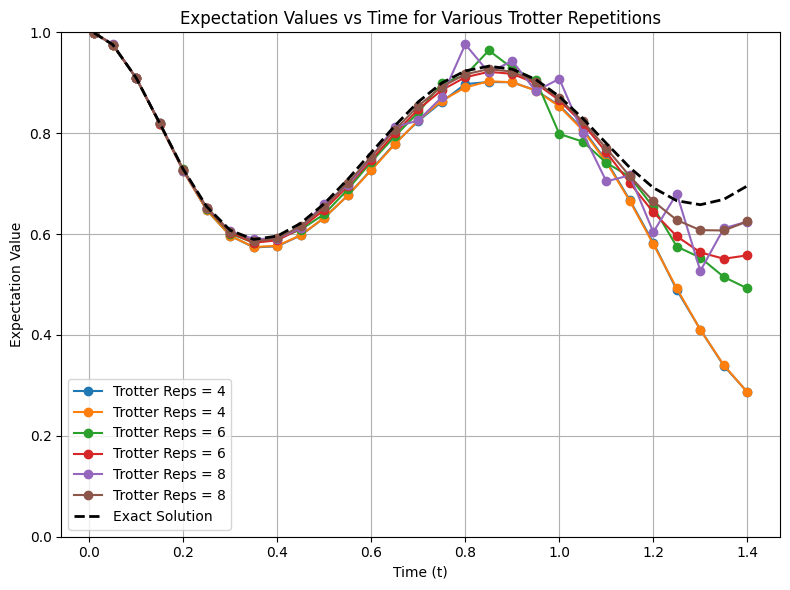

In [34]:
    # After all simulations, process and plot the results
    # Convert exact_values and approx_values to arrays for plotting
    sorted_t_list = sorted(t_list[:-11])
    sorted_trotter_reps = sorted(trotter_reps_list)  # Exclude 100 for approx

    # Prepare data for plotting
    # For each trotter_rep, collect expectation values over t
    trotter_expvals = {reps: [] for reps in sorted_trotter_reps}
    exact_expvals = []

    for t in sorted_t_list:
        exact_expvals.append(exact_values[t])
        for reps in sorted_trotter_reps:
            approx_val = approx_values[t].get(reps, np.nan)  # Use NaN if not available
            trotter_expvals[reps].append(approx_val)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Plot expectation values for each trotter_rep
    for reps in sorted_trotter_reps:
        plt.plot(sorted_t_list, trotter_expvals[reps], marker='o', linestyle='-', label=f'Trotter Reps = {reps}')

    # Plot the exact solution
    plt.plot(sorted_t_list, exact_expvals, color='black', linestyle='--', linewidth=2, label='Exact Solution')

    plt.title('Expectation Values vs Time for Various Trotter Repetitions')
    plt.xlabel('Time (t)')
    plt.ylabel('Expectation Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(0,1)
    plt.show()

In [40]:
filename = "plot_data.txt"
with open(filename, "w") as file:
    file.write("Time Points (sorted_t_list):\n")
    file.write(", ".join(map(str, sorted_t_list)) + "\n\n")
    for reps in sorted_trotter_reps:
        file.write(f"Trotter Reps = {reps} (trotter_expvals[{reps}]):\n")
        file.write(", ".join(map(str, trotter_expvals[reps])) + "\n\n")
    file.write("Exact Solution (exact_expvals):\n")
    file.write(", ".join(map(str, exact_expvals)) + "\n")

filename

'plot_data.txt'

In [36]:
!cd

c:\Users\pably\Documents\Master\Quantum Science and Engineering\MA3\Semester project II\Coding\tensor-knitting\implementation
